In [102]:
import os
import shutil
import numpy as np
import pandas as pd
 
from PIL import Image
from glob import glob
import xml.etree.ElementTree as ET 
 
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [103]:
xml_paths = glob("./image/*.xml")
image_list = []

image_dir_path = './concrete_detection_image'
if not (os.path.exists(image_dir_path)):
        os.makedirs(image_dir_path)

for xml in xml_paths:
    filename = xml.split('/')[-1].split('.')[-2]
    image_path = './image/'+filename+'.jpg'
    image_list.append(image_path)
    im = Image.open(image_path)
    im.save(image_dir_path+'/'+filename+'.jpg')
    shutil.copy(xml, image_dir_path+'/'+filename+'.xml')

In [104]:
class xml2list(object):
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path):
        
        ret = []
        xml = ET.parse(xml_path).getroot()
        
        for size in xml.iter("size"):     
            width = float(size.find("width").text)
            height = float(size.find("height").text)
                
        for obj in xml.iter("object"):
            difficult = int(obj.find("difficult").text)
            if difficult == 1:
                continue          
            bndbox = [width, height]        
            name = obj.find("name").text.lower().strip() 
            bbox = obj.find("bndbox")            
            pts = ["xmin", "ymin", "xmax", "ymax"]     
            for pt in pts:         
                cur_pixel =  float(bbox.find(pt).text)               
                bndbox.append(cur_pixel)           
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)    
            ret += [bndbox]
            
        return np.array(ret) # [width, height, xmin, ymin, xamx, ymax, label_idx]

In [115]:
# XMLファイルの列挙
xml_paths = glob("./image/*.xml")
# クラスの定義
classes = ["concrete"]
# transform to array
transform_anno = xml2list(classes)

In [116]:
df = pd.DataFrame(columns=["image_id", "width", "height", "xmin", "ymin", "xmax", "ymax", "class"])
print(df)

Empty DataFrame
Columns: [image_id, width, height, xmin, ymin, xmax, ymax, class]
Index: []


In [117]:
for path in xml_paths:
    image_id = path.split("/")[-1].split(".")[0]
    bboxs = transform_anno(path)
    
    for bbox in bboxs:
        tmp = pd.Series(bbox, index=["width", "height", "xmin", "ymin", "xmax", "ymax", "class"])
        tmp["image_id"] = image_id
        df = df.append(tmp, ignore_index=True)
print(df['class'].value_counts())

0.0    210
Name: class, dtype: int64


In [118]:
df = df.sort_values(by="image_id", ascending=True)

In [119]:
df["class"] = df["class"] + 1

In [162]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, image_dir):
        
        super().__init__()
        
        self.image_ids = df["image_id"].unique()
        self.df = df
        self.image_dir = image_dir
        
    def __getitem__(self, index):
        
        # Data Augumation
        transform = transforms.Compose([ transforms.ToTensor() ])
        
        # 入力画像の読み込み
        image_id = self.image_ids[index]
        image = Image.open(f"{self.image_dir}/{image_id}.jpg")
        # To Tensor
        image = transform(image)
        
        # アノテーションデータの読み込み
        records = self.df[self.df["image_id"] == image_id]
        boxes = torch.tensor(records[["xmin", "ymin", "xmax", "ymax"]].values, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        print(area)
        
        labels = torch.tensor(records["class"].values, dtype=torch.int64)
        
        iscrowd = torch.zeros((records.shape[0], ), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"]= labels
        target["image_id"] = torch.tensor([index])
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return image, target, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [160]:
image_dir = "./concrete_detection_image/"
dataset = MyDataset(df, image_dir)

90
torch.Size([3, 1650, 4579])
tensor([ 727296., 2676000.,  664346., 2368636.])
torch.Size([3, 1650, 4579])


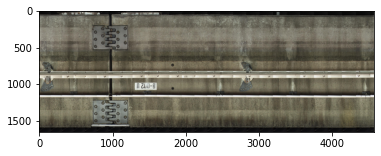

In [167]:
print(len(dataset))
images, target, image_id = dataset[0]
print(images.shape)
plt.imshow(images.permute(1,2,0))

In [123]:
torch.manual_seed(2020)
 
n_train = int(len(dataset) * 0.7)
n_val = len(dataset) - n_train

print(n_train)
print(n_val)
 
train, val = torch.utils.data.random_split(dataset, [n_train, n_val])
 
def collate_fn(batch):
    return tuple(zip(*batch))
 
train_dataloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False, collate_fn=collate_fn)

62
28


In [124]:
print(train_dataloader)

In [128]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
num_classes = 2 # background, concrete
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [148]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
num_epochs = 5
 
for epoch in range(num_epochs):
    
    model.train()
    
    for i, batch in enumerate(train_dataloader):
        
        images, targets, image_ids = batch
        
        
        print(len(images))
        print(len(targets))
        print(images[0].shape)
    cuda
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        pred = model(images, targets)
        losses = sum(loss for loss in pred.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}")  

cuda:0
tensor([2650710., 2464106.])
tensor([2563758., 2507022.,  568002.,  578795.])
tensor([ 635916., 2569798.])
tensor([2511380.,  714987.])
4
4
torch.Size([3, 1650, 3579])


RuntimeError: CUDA error: device-side assert triggered

In [127]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)
model.eval()
 
images, targets, image_ids = next(iter(val_dataloader))
 
images = list(img.to(device) for img in images)
outputs = model(images)
 
for i, image in enumerate(images):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = Image.fromarray((image * 255).astype(np.uint8))
    
    boxes = outputs[i]["boxes"].data.cpu().numpy()
    scores = outputs[i]["scores"].data.cpu().numpy()
    labels = outputs[i]["labels"].data.cpu().numpy()
    
    category = {0: "background", 1: "concrete"}
    
    boxes = boxes[scores >= 0.5].astype(np.int32)
    scores = scores[scores >= 0.5]
    image_id = image_ids[i]
    
for i, box in enumerate(boxes):
    draw = ImageDraw.Draw(image)
    label = category[labels[i]]
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)
    
    # ラベルの表示
    fnt = ImageFont.truetype('/content/mplus-1c-black.ttf', 20)
    text_w, text_h = fnt.getsize(label)
    draw.rectangle([box[0], box[1], box[0]+text_w, box[1]+text_h], fill="red")
    draw.text((box[0], box[1]), label, font=fnt, fill='white')
    
image.save(f"resample_{str(i)}.png")
fig, ax = plt.subplots(1, 1)
ax.imshow(np.array(image))

RuntimeError: CUDA error: device-side assert triggered